In [34]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [36]:
base_dir = '/home/iplab/Desktop/Shaker/Brain tumor MRI and CT scan/data(processed)'

# read mr and ct datasets
MR_train_address = os.path.join(base_dir, 'train_input.npy')
CT_train_address = os.path.join(base_dir, 'train_output.npy')

MR_val_address = os.path.join(base_dir, 'val_input.npy')
CT_val_address = os.path.join(base_dir, 'val_output.npy')

MR_test_address = os.path.join(base_dir, 'test_input.npy')
CT_test_address = os.path.join(base_dir, 'test_output.npy')

mr_train = np.load(MR_train_address)
ct_train = np.load(CT_train_address)

mr_val = np.load(MR_val_address)
ct_val = np.load(CT_val_address)

mr_test = np.load(MR_test_address)
ct_test = np.load(CT_test_address)

ct_train.shape, ct_val.shape, ct_test.shape

((570, 256, 256), (90, 256, 256), (150, 256, 256))

In [37]:
# resizes a 1d numpy array to an arbitrary size
def resize(img, size):

  img = img.astype('float32')
  img = torch.tensor(img)
  img = img.unsqueeze(0)

  transform = T.Resize(size)
  resized_img = transform(img)

  # resized_img = np.array(resized_img)

  return resized_img

In [38]:
change_gray_level = T.Compose([
    T.Lambda(lambda t: t * 0.2)
])

horizontal_flip = T.Compose([
    T.functional.hflip
])

vertical_flip = T.Compose([
    T.functional.vflip
])

rotate_45 = T.Compose([
    T.Lambda(lambda t: T.functional.rotate(t, angle=45))
])

rotate_minus_45 = T.Compose([
    T.Lambda(lambda t: T.functional.rotate(t, angle=-45))
])

In [39]:
n_train_samples = ct_train.shape[0]
n_val_samples = ct_val.shape[0]
n_test_samples = ct_test.shape[0]

# remove 90 samples from test data and add it to train data
n_add_from_test_to_train = 69

n_train_new = n_train_samples + n_val_samples + n_add_from_test_to_train
n_test_new = n_test_samples - n_add_from_test_to_train

# data augmentation
# add 5 varient of each sample
# so our train dataset will be 6 times bigger

n_train_new = n_train_new * 6
# n_train_new = n_train_new * 3

mr_train_resized = [None] * n_train_new
ct_train_resized = [None] * n_train_new

mr_test_resized = [None] * n_test_new
ct_test_resized = [None] * n_test_new

# train samples with augmentation
for i in range(n_train_samples):

  j = i * 6
  # j = i*3
  # j = i

  resized_mr = resize(mr_train[i], 128)

  mr_train_resized[j] = resized_mr
  mr_train_resized[j+1] = change_gray_level(resized_mr)
  mr_train_resized[j+2] = horizontal_flip(resized_mr)
  mr_train_resized[j+3] = vertical_flip(resized_mr)
  mr_train_resized[j+4] = rotate_45(resized_mr)
  mr_train_resized[j+5] = rotate_minus_45(resized_mr)

  resized_ct = resize(ct_train[i], 128)

  ct_train_resized[j] = resized_ct
  ct_train_resized[j+1] = change_gray_level(resized_ct)
  ct_train_resized[j+2] = horizontal_flip(resized_ct)
  ct_train_resized[j+3] = vertical_flip(resized_ct)
  ct_train_resized[j+4] = rotate_45(resized_ct)
  ct_train_resized[j+5] = rotate_minus_45(resized_ct)


# validation samples with augmentation
for i in range(n_val_samples):

  j = i*6 + n_train_samples*6
  # j = i*3 + n_train_samples*3
  # j = i + n_train_samples

  resized_mr = resize(mr_val[i], 128)

  mr_train_resized[j] = resized_mr
  mr_train_resized[j+1] = change_gray_level(resized_mr)
  mr_train_resized[j+2] = horizontal_flip(resized_mr)
  mr_train_resized[j+3] = vertical_flip(resized_mr)
  mr_train_resized[j+4] = rotate_45(resized_mr)
  mr_train_resized[j+5] = rotate_minus_45(resized_mr)

  resized_ct = resize(ct_val[i], 128)

  ct_train_resized[j] = resized_ct
  ct_train_resized[j+1] = change_gray_level(resized_ct)
  ct_train_resized[j+2] = horizontal_flip(resized_ct)
  ct_train_resized[j+3] = vertical_flip(resized_ct)
  ct_train_resized[j+4] = rotate_45(resized_ct)
  ct_train_resized[j+5] = rotate_minus_45(resized_ct)


# part of test samples with augmentation

for i in range(n_add_from_test_to_train):

  j = i*6 + n_train_samples*6 + n_val_samples*6
  # j = i*3 + n_train_samples*3 + n_val_samples*3
  # j = i + n_train_samples + n_val_samples

  resized_mr = resize(mr_test[i], 128)

  mr_train_resized[j] = resized_mr
  mr_train_resized[j+1] = change_gray_level(resized_mr)
  mr_train_resized[j+2] = horizontal_flip(resized_mr)
  mr_train_resized[j+3] = vertical_flip(resized_mr)
  mr_train_resized[j+4] = rotate_45(resized_mr)
  mr_train_resized[j+5] = rotate_minus_45(resized_mr)

  resized_ct = resize(ct_test[i], 128)

  ct_train_resized[j] = resized_ct
  ct_train_resized[j+1] = change_gray_level(resized_ct)
  ct_train_resized[j+2] = horizontal_flip(resized_ct)
  ct_train_resized[j+3] = vertical_flip(resized_ct)
  ct_train_resized[j+4] = rotate_45(resized_ct)
  ct_train_resized[j+5] = rotate_minus_45(resized_ct)

# test samples
for i in range(n_test_new):

  j = i + n_add_from_test_to_train

  mr_test_resized[i] = resize(mr_test[j], 128)
  ct_test_resized[i] = resize(ct_test[j], 128)

/home/iplab/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [40]:
# convert train and test samples to numpy array
for i in range(n_train_new):
  mr_train_resized[i] = np.array(mr_train_resized[i].squeeze())
  ct_train_resized[i] = np.array(ct_train_resized[i].squeeze())

for i in range(n_test_new):
  mr_test_resized[i] = np.array(mr_test_resized[i].squeeze())
  ct_test_resized[i] = np.array(ct_test_resized[i].squeeze())

In [41]:
# convert lists of mr and ct to numpy arrays
mr_train_resized = np.array(mr_train_resized)

ct_train_resized = np.array(ct_train_resized)

mr_test_resized = np.array(mr_test_resized)

ct_test_resized = np.array(ct_test_resized)


print('train images shape:', mr_train_resized.shape)
print('test images shape:', mr_test_resized.shape)

train images shape: (4374, 128, 128)
test images shape: (81, 128, 128)


In [42]:
import h5py

# creating hdf5 data from numpy arrays
with h5py.File('mr_train_resized.hdf5', 'w') as f:
    dset = f.create_dataset("data", data = mr_train_resized)

with h5py.File('ct_train_resized.hdf5', 'w') as f:
    dset = f.create_dataset("data", data = ct_train_resized)

with h5py.File('mr_test_resized.hdf5', 'w') as f:
    dset = f.create_dataset("data", data = mr_test_resized)

with h5py.File('ct_test_resized.hdf5', 'w') as f:
    dset = f.create_dataset("data", data = ct_test_resized)

In [43]:
path = 'mr_train_resized.hdf5'
f = h5py.File(path,'r')
load_data = f['data']
load_data

<HDF5 dataset "data": shape (4374, 128, 128), type "<f4">

In [44]:
# train.py DDPM folder
import sys
import copy
import os
import warnings
import scipy.io as sio
from absl import app, flags
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import gridspec

import torch
from torch.utils.data import DataLoader

from diffusion import GaussianDiffusionTrainer, GaussianDiffusionSampler
from model import UNet
from dataset import Train_Data, Test_Data


train = True
continue_train = False

# UNet
ch = 64
ch_mult = [1, 2, 2, 4, 4]
attn = [1]
num_res_blocks = 2
dropout = 0.

# Gaussian Diffusion
beta_1 = 1e-4
beta_T = 0.02
T = 1000

# Training
lr = 1e-4
grad_clip = 1.
img_size = 128
batch_size = 2
num_workers = 1
ema_decay = 0.9999

sample_size = 1

min_epoch = 100
max_epoch = 110
n_prev_epochs = 20

epoch_mean_loss = max_epoch * [None]
# Logging & Sampling
DIREC = f'ddpm-unet_n-train-samples_{n_train_new}_n-test-samples_{n_test_new}_batch-size_{batch_size}_T_{T}_img-size_{img_size}_data_augmentation_all'

device = torch.device('cuda:0')


def ema(source, target, decay):
    source_dict = source.state_dict()
    target_dict = target.state_dict()
    for key in source_dict.keys():
        target_dict[key].data.copy_(
            target_dict[key].data * decay +
            source_dict[key].data * (1 - decay))

def train():

    # dataset
    train_data = Train_Data()
    train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,
                             pin_memory=True, shuffle=True)

    # model setup
    net_model = UNet(
        T=T, ch=ch, ch_mult=ch_mult, attn=attn,
        num_res_blocks=num_res_blocks, dropout=dropout)
    ema_model = copy.deepcopy(net_model)

    net_model.to(device)
    ema_model.to(device)


    optim = torch.optim.Adam(net_model.parameters(), lr=lr)

    trainer = GaussianDiffusionTrainer(
        net_model, beta_1, beta_T, T).to(device)


    # show model size
    model_size = 0
    for param in net_model.parameters():
        model_size += param.data.nelement()
    print('Model params: %.2f M' % (model_size / 1024 / 1024))


    if not os.path.exists('current experiment'):
        os.makedirs('current experiment')


    if not os.path.exists('./current experiment/diff_results'):
        os.makedirs('./current experiment/diff_results')

    if not os.path.exists('./current experiment/Saved_model'):
        os.makedirs('./current experiment/Saved_model')


    for epoch in range(0, max_epoch):
        with tqdm(train_loader, unit="batch") as tepoch:
            tmp_tr_loss = 0
            tr_sample = 0
            net_model.train()
            for data, target in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")

                # train
                optim.zero_grad()
                condition = data.to(device)
                x_0 = target.to(device)

                loss = trainer(x_0, condition)
                tmp_tr_loss += loss.item()
                tr_sample += len(data)

                loss.backward()

                torch.nn.utils.clip_grad_norm_(
                    net_model.parameters(), grad_clip)
                optim.step()
                ema(net_model, ema_model, ema_decay)

                tepoch.set_postfix({'Loss': loss.item()})
        
        mean_loss = tmp_tr_loss / tr_sample
        print('mean loss', mean_loss)

        epoch_mean_loss[epoch] = mean_loss
        
        if epoch+1 > min_epoch:
          prev_mean_loss = 0
          
          for i in range(n_prev_epochs):
            prev_mean_loss += epoch_mean_loss[epoch - (i+1)]

          prev_mean_loss /= n_prev_epochs
          
          if mean_loss > (prev_mean_loss - 0.01*prev_mean_loss):
            break        

    torch.save(ema_model.state_dict(), f'./current experiment/Saved_model/ddpm-unet_epoch_{epoch+1}.pt')
    
    return epoch+1

In [45]:
last_epoch_num = train()

  0%|          | 0/2187 [00:00<?, ?batch/s]

Model params: 24.91 M


  0%|          | 0/2187 [00:00<?, ?batch/s]

mean loss 0.014703570082737922


Epoch 2: 100%|██████████| 2187/2187 [02:38<00:00, 13.82batch/s, Loss=0.00223] 


mean loss 0.0040241724630550235


In [48]:
def test():

    if not os.path.exists('./current experiment/Train_Output/' + DIREC):
        os.makedirs('./current experiment/Train_Output/' + DIREC)

    ddpm_sum_time = 0
    
    test_data = Test_Data()
    test_loader = DataLoader(test_data, batch_size=sample_size, num_workers=num_workers,
                                pin_memory=True, shuffle=False)

    net_model = UNet(
    T=T, ch=ch, ch_mult=ch_mult, attn=attn,
    num_res_blocks=num_res_blocks, dropout=dropout)
    
    ema_model = copy.deepcopy(net_model)

    model_path = f'./current experiment/Saved_model/ddpm-unet_epoch_{last_epoch_num}.pt'

    ema_model.load_state_dict(torch.load(model_path))

    ema_sampler = GaussianDiffusionSampler(
    ema_model, beta_1, beta_T, T, img_size).to(device)


    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            # if idx <= 1:
                x_T = torch.randn(sample_size, 1, img_size, img_size)
                x_T = x_T.to(device)

                condition = data.to(device)

                tic_ddpm = time.time()
                x_0 = ema_sampler(x_T, condition)
                toc_ddpm = time.time()

                time_interval_ddpm = toc_ddpm - tic_ddpm
                ddpm_sum_time += time_interval_ddpm
                
                ddpm_out = x_0[-1]
                ddpm_out = np.array(ddpm_out.cpu())

                save_path = f'./current experiment/diff_results/x0_number_{idx+1}_epoch_{last_epoch_num}.npy'
                np.save(save_path, ddpm_out)

                fig = plt.figure()
                fig.set_figheight(8)
                fig.set_figwidth(28)
                spec = gridspec.GridSpec(ncols=7, nrows=2,
                        width_ratios=[1,1,1,1,1,1,1], wspace=0.01,
                        hspace=0.01, height_ratios=[1,1],left=0,right=1,top=1,bottom=0)

                img = data[0].data.squeeze()
                ax = fig.add_subplot(spec[0])
                ax.imshow(img, cmap='gray', vmin=0,vmax=1)
                ax.axis('off')

                count = 1
                for kk in range(5): # x_0 [5,b,1,h,w]
                    imgs = x_0[kk] # imgs [b,1,h,w]
                    img = imgs[0].data.squeeze().cpu()
                    ax = fig.add_subplot(spec[count])
                    ax.imshow(img, cmap='gray', vmin=0,vmax=1)
                    ax.axis('off')

                    count += 1

                img = target[0].data.squeeze().cpu()
                ax = fig.add_subplot(spec[6])
                ax.imshow(img, cmap='gray', vmin=0,vmax=1)
                ax.axis('off')

                plt.savefig('./current experiment/Train_Output/'+ DIREC + '/Epoch_' + str(last_epoch_num) + '.png',
                            bbox_inches='tight', pad_inches=0)

    return ddpm_sum_time


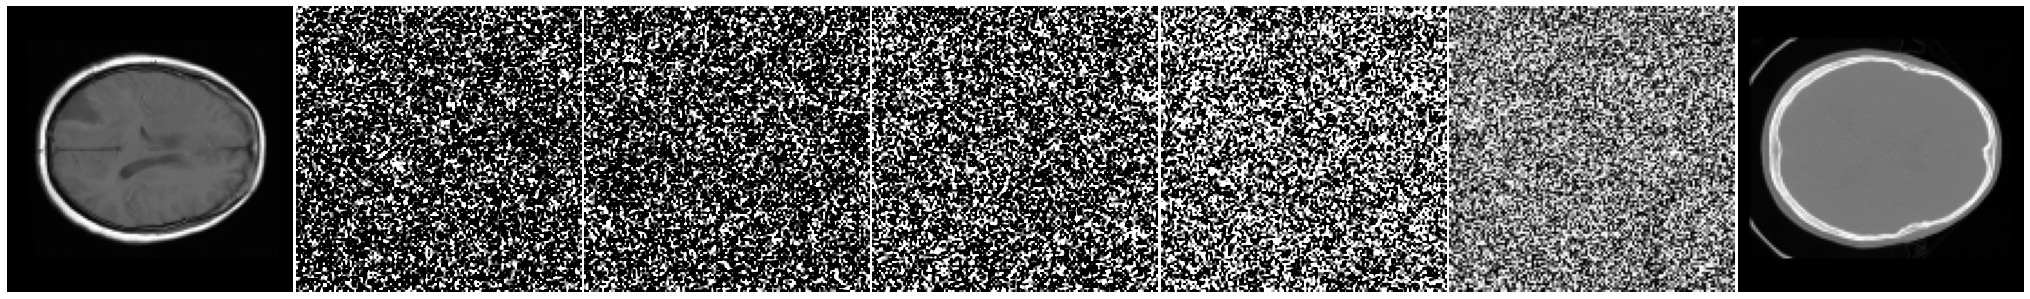

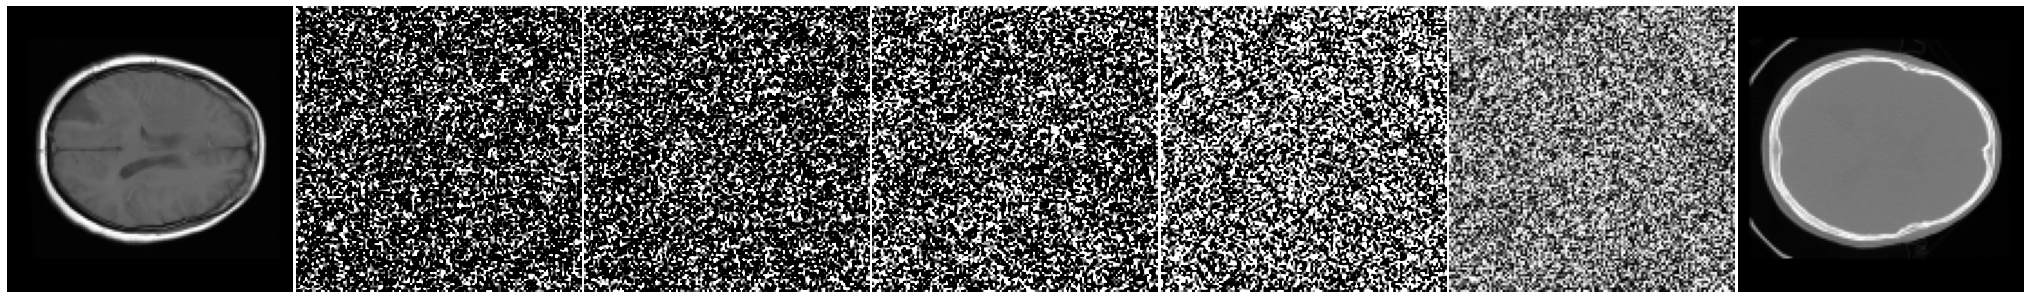

In [51]:
ddpm_sum_time = test()

In [52]:
ddpm_avg_time = ddpm_sum_time / (n_test_new * last_epoch_num)
ddpm_avg_time

0.1568069119512299

In [56]:
diff_outs = [None] * n_test_new

for i in range(n_test_new):
  diff_out = np.load(f'./current experiment/diff_results/x0_number_{i+1}_epoch_{last_epoch_num}.npy')
  diff_out = np.reshape(diff_out, (1, img_size, img_size))
  diff_out = torch.tensor(diff_out)
  diff_outs[i] = diff_out.unsqueeze(0)

In [57]:
from ignite.metrics import PSNR, SSIM
from collections import OrderedDict

import torch
from torch import nn, optim

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

In [58]:
targets = [None] * n_test_new

for i in range(n_test_new):
  ct_sample = ct_test_resized[i]
  ct_sample = np.reshape(ct_sample, (1, img_size, img_size))
  ct_sample = torch.tensor(ct_sample)
  targets[i] = ct_sample.unsqueeze(0)


In [60]:
metric = SSIM(data_range=1.0)
metric.attach(default_evaluator, 'ssim')


sum_ssims = 0

for i in range(n_test_new):
  state = default_evaluator.run([[diff_outs[i], targets[i]]])
  ssim_value = state.metrics['ssim']
  # print(ssim_value)
  sum_ssims += ssim_value

avg_ssim = sum_ssims / n_test_new

avg_ssim

9.63063569984002e-05

In [61]:
metric = PSNR(data_range=1.0)
metric.attach(default_evaluator, 'psnr')


sum_psnrs = 0

for i in range(n_test_new):
  state = default_evaluator.run([[diff_outs[i], targets[i]]])
  psnr_value = state.metrics['psnr']
  # print(ssim_value)
  sum_psnrs += psnr_value

avg_psnr = sum_psnrs / n_test_new

avg_psnr

0.15510990506980699

In [ ]:
# # average
# ssim: 
# psnr: 